# Technical note: Simulation with sensitivities test case

## Derivative expressions

In this notebook we set up a simple model and look at derivatives involving derivative expressions, e.g. the sensitivity of `dot(y)` or the sensitivity of an intermediary variable that depends on `dot(y)`.

Model:

\begin{align}
t_0     &\equiv 0 \\
p       &= 1 / 100 \\
q       &= 2 \\
r       &= 3 \\
x(t_0)  &= x_0 = 1.2 \\
y(t_0)  &= y_0 = 2.3 \\
\dot{x} &= pq \\
\dot{y} &= 2p - y \\
f_x     &= x^2 \\
f_y     &= r + p^2 + \dot{y}
\end{align}

Solutions:
\begin{align}
x(t)       &= x_0 + pqt \\
y(t)       &= 2p + (y_0 - 2p) e^{-t} \\
\dot{x}(t) &= pq \\
\dot{x}(t) &= (2p - y_0) e^{-t} \\
f_x(t)     &= (pqt)^2 + 2pqtx_0 + x_0^2 \\
f_y(t)     &= r + p^2 + (2p - y_0) e^{-t}
\end{align}

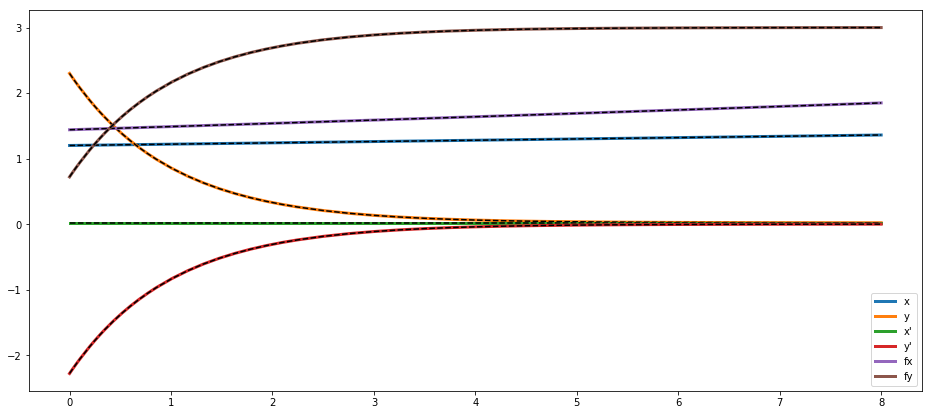

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

m = myokit.parse_model('''
[[model]]
e.x = 1.2
e.y = 2.3

[e]
t = 0 bind time
p = 1 / 100
q = 2
r = 3
dot(x) = p * q
dot(y) = 2 * p - y
fx = x^2
fy = r + p^2 + dot(y)
''')
m.validate()

s = myokit.Simulation(m)
d = s.run(8).npview()
t = d.time()

x0 = m.get('e.x').state_value()
y0 = m.get('e.y').state_value()
p = m.get('e.p').eval()
q = m.get('e.q').eval()
r = m.get('e.r').eval()

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, d['e.x'], lw=3, label='x')
ax.plot(t, x0 + p * q * t, 'k--')
ax.plot(t, d['e.y'], lw=3, label='y')
ax.plot(t, 2 * p + (y0 - 2 * p) * np.exp(-t), 'k--')
ax.plot(t, d['dot(e.x)'], lw=3, label="x'")
ax.plot(t, np.ones(t.shape) * p * q, 'k--')
ax.plot(t, d['dot(e.y)'], lw=3, label="y'")
ax.plot(t, (2 * p - y0) * np.exp(-t), 'k--')
ax.plot(t, d['e.fx'], lw=3, label='fx')
ax.plot(t, (p * q * t)**2 + 2 * p * q * t * x0 + x0**2, 'k--')
ax.plot(t, d['e.fy'], lw=3, label='fy')
ax.plot(t, r + p**2 + (2 * p - y0) * np.exp(-t), 'k--')
ax.legend()
plt.show()

Sensitivities of $x = x_0 + pqt$:
\begin{align}
\left.\frac{\partial x}{\partial p}\right\rvert_t &= qt \\
\left.\frac{\partial x}{\partial q}\right\rvert_t &= pt \\
\left.\frac{\partial x}{\partial x_0}\right\rvert_t &= 1 \\
\end{align}
And of $\dot{x} = pq$:
\begin{align}
\left.\frac{\partial \dot{x}}{\partial p}\right\rvert_t &= q \\
\left.\frac{\partial \dot{x}}{\partial q}\right\rvert_t &= p \\
\left.\frac{\partial \dot{x}}{\partial x_0}\right\rvert_t &= 0
\end{align}

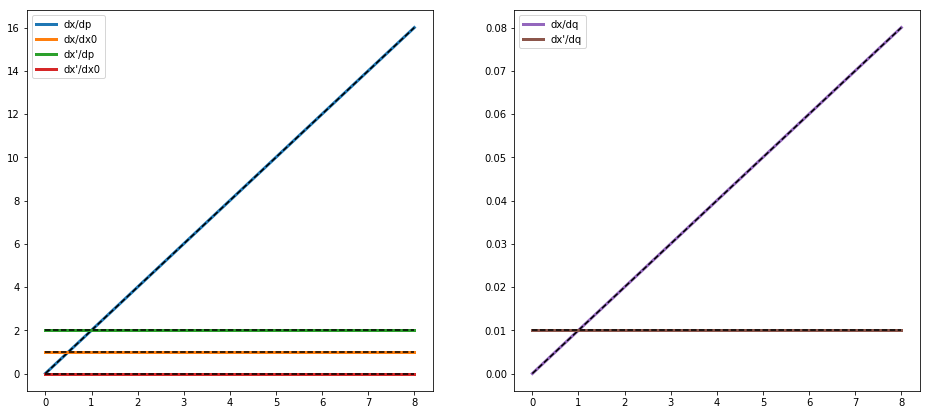

In [3]:
sens = (['e.x', 'dot(e.x)'], ['e.p', 'e.q', 'init(e.x)'])

s = myokit.Simulation(m, sensitivities=sens)
d, e = s.run(8)
d, e = d.npview(), np.array(e)
t = d.time()

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, e[:, 0, 0], lw=3, label='dx/dp')
ax.plot(t, q * t, 'k--')
ax.plot(t, e[:, 0, 2], lw=3, label='dx/dx0')
ax.plot(t, np.ones(t.shape), 'k--')
ax.plot(t, e[:, 1, 0], lw=3, label="dx'/dp")
ax.plot(t, q * np.ones(t.shape), 'k--')
ax.plot(t, e[:, 1, 2], lw=3, label="dx'/dx0")
ax.plot(t, np.zeros(t.shape), 'k--')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, e[:, 0, 1], lw=3, color='tab:purple', label='dx/dq')
ax.plot(t, p * t, 'k--')
ax.plot(t, e[:, 1, 1], lw=3, color='tab:brown', label="dx'/dq")
ax.plot(t, p * np.ones(t.shape), 'k--')
ax.legend()
plt.show()

Sensitivities of $y = 2p + (y_0 - 2p) e^{-t}$:
\begin{align}
\left.\frac{\partial y}{\partial p}\right\rvert_t &= 2 - 2e^{-t} \\
\left.\frac{\partial y}{\partial y_0}\right\rvert_t &= e^{-t} \\
\end{align}
And of $\dot{y} = (2p - y_0) e^{-t}$:
\begin{align}
\left.\frac{\partial \dot{y}}{\partial p}\right\rvert_t &= 2e^{-t} \\
\left.\frac{\partial \dot{y}}{\partial y_0}\right\rvert_t &= -e^{-t} 
\end{align}

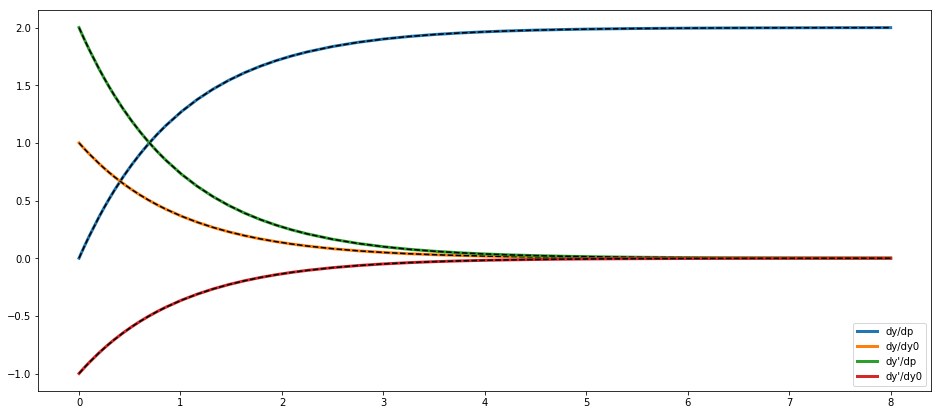

In [4]:
sens = (['e.y', 'dot(e.y)'], ['e.p', 'init(e.y)'])

s = myokit.Simulation(m, sensitivities=sens)
d, e = s.run(8)
d, e = d.npview(), np.array(e)
t = d.time()

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, e[:, 0, 0], lw=3, label='dy/dp')
ax.plot(t, 2 - 2 * np.exp(-t), 'k--')
ax.plot(t, e[:, 0, 1], lw=3, label='dy/dy0')
ax.plot(t, np.exp(-t), 'k--')
ax.plot(t, e[:, 1, 0], lw=3, label="dy'/dp")
ax.plot(t, 2 * np.exp(-t), 'k--')
ax.plot(t, e[:, 1, 1], lw=3, label="dy'/dy0")
ax.plot(t, -np.exp(-t), 'k--')
ax.legend()
plt.show()

Sensitivities of $f_x= (pqt)^2 + 2pqtx_0 + x_0^2$:
\begin{align}
\left.\frac{\partial f_x}{\partial p}\right\rvert_t &= 2p(qt)^2 + 2qtx_0 \\
\left.\frac{\partial f_x}{\partial q}\right\rvert_t &= 2p(qt)^2 + 2ptx_0 \\
\left.\frac{\partial f_x}{\partial x_0}\right\rvert_t &= 2pqt + 2x_0
\end{align}

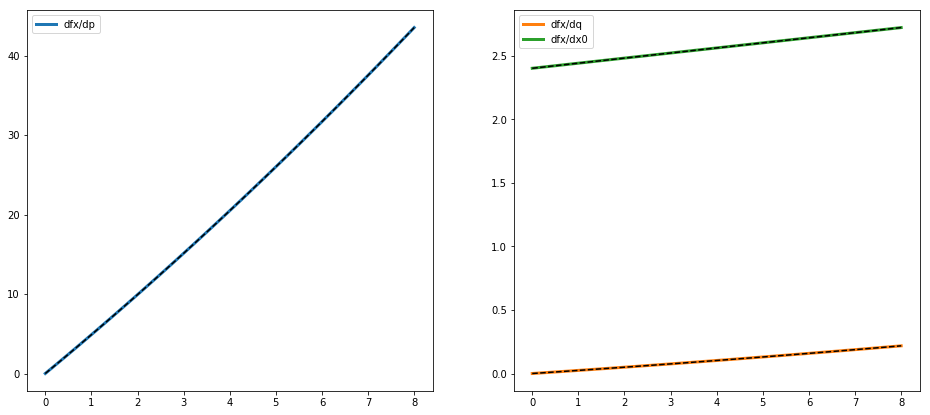

In [5]:
sens = (['e.fx'], ['e.p', 'e.q', 'init(e.x)'])

s = myokit.Simulation(m, sensitivities=sens)
d, e = s.run(8)
d, e = d.npview(), np.array(e)
t = d.time()

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, e[:, 0, 0], lw=3, label='dfx/dp')
ax.plot(t, 2 * p * (q * t)**2 + 2 * q * t * x0, 'k--')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, e[:, 0, 1], lw=3, color='tab:orange', label='dfx/dq')
ax.plot(t, 2 * q * (p * t)**2 + 2 * p * t * x0, 'k--')
ax.plot(t, e[:, 0, 2], color='tab:green', lw=3, label='dfx/dx0')
ax.plot(t, 2 * p * q * t + 2 * x0, 'k--')
ax.legend()
plt.show()

Sensitivities of $f_y= r + p^2 + (2p - y_0) e^{-t}$:
\begin{align}
\left.\frac{\partial f_y}{\partial p}\right\rvert_t &= 2p + 2e^{-t} \\
\left.\frac{\partial f_y}{\partial p}\right\rvert_t &= 1 \\
\left.\frac{\partial f_y}{\partial y_0}\right\rvert_t &= -e^{-t}
\end{align}

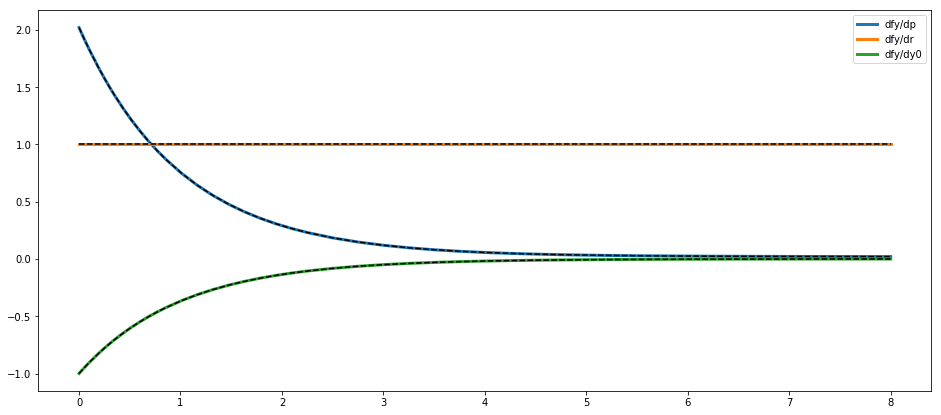

In [6]:
sens = (['e.fy'], ['e.p', 'e.r', 'init(e.y)'])

s = myokit.Simulation(m, sensitivities=sens)
d, e = s.run(8)
d, e = d.npview(), np.array(e)
t = d.time()

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, e[:, 0, 0], lw=3, label='dfy/dp')
ax.plot(t, 2 * p + 2 * np.exp(-t), 'k--')
ax.plot(t, e[:, 0, 1], lw=3, label='dfy/dr')
ax.plot(t, np.ones(t.shape), 'k--')
ax.plot(t, e[:, 0, 2], lw=3, label='dfy/dy0')
ax.plot(t, -np.exp(-t), 'k--')
ax.legend()
plt.show()